### Step #0: Import files / initialize the pipeline

In [54]:
import os
os.chdir('../CCP_Collab_Backup_2/')
from cfg import *
import Allen_API_Library as ParL
imp.reload(ParL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import PrimaryLibrary as PL
imp.reload(PL)
MesoPred = PL.MesoconnectomePredictor()
os.chdir('../')
import Various_Library as VL
imp.reload(VL)
os.chdir('VolumetricAnalysis/')
import Meta_FLICA_library as FL
imp.reload(FL)
sys.path.append("FLICA_dependences")
from flica import flica 
import flica_various as alb_various
sys.path.insert(0,'../../ecallen/')
from ecallen import images_p2 as ecimg
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 1199860004 

### Step #1: Load and Pre-Process Volumetric data

In [3]:
# Loading function
M, InputData, annotation200, annot_200_res = FL.VolumeLoader()

# command for relative modality contributions
pc=np.divide(M['H_PCs'][0:-1][:],np.tile(np.sum(M['H_PCs'][0:-1][:],0),[M['H_PCs'].shape[0]-1, 1] )) 

# Pre-Processing function: Collapses the three spatial dimension in one using column-major order, 
# removes the background voxels that don't belong to the brain, and z-scores the data
Data_Modality, Data_Modality_sc, Non_zero_voxels = FL.PreProcessing(InputData)
print Data_Modality[0].shape, Data_Modality[1].shape,Data_Modality_sc[0].shape, Data_Modality_sc[1].shape 

con_shape          = np.shape(Data_Modality[1])
shape_of_200       = annotation200[0].shape


(67, 41, 58, 3318)
(67, 41, 58, 498)
(3318, 63113) (498, 63113) (3318, 63113) (498, 63113)


### Post-hoc summaries: acquiring tables summarizing the brain regions involved in the color-coded, tract and shared spatial maps

['Visual'] bimodal
['Visual'] gene
['Visual'] projection



['Midbrain', 'Caudoputamen'] bimodal
['Midbrain', 'Caudoputamen'] gene
['Midbrain', 'Caudoputamen'] projection



['Global'] bimodal
['Global'] gene
['Global'] projection



['Visual']



['Midbrain', 'Caudoputamen']



['Global']



['Visual']



['Midbrain', 'Caudoputamen']



['Global']





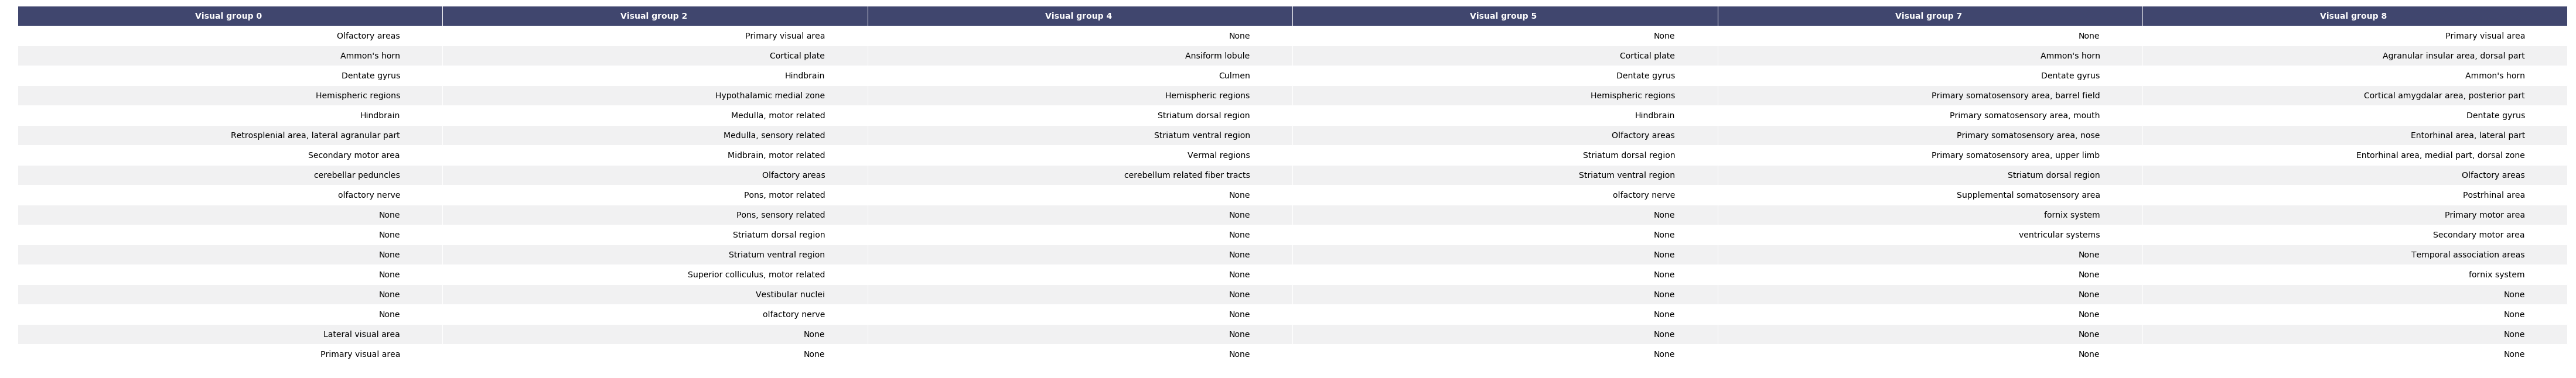

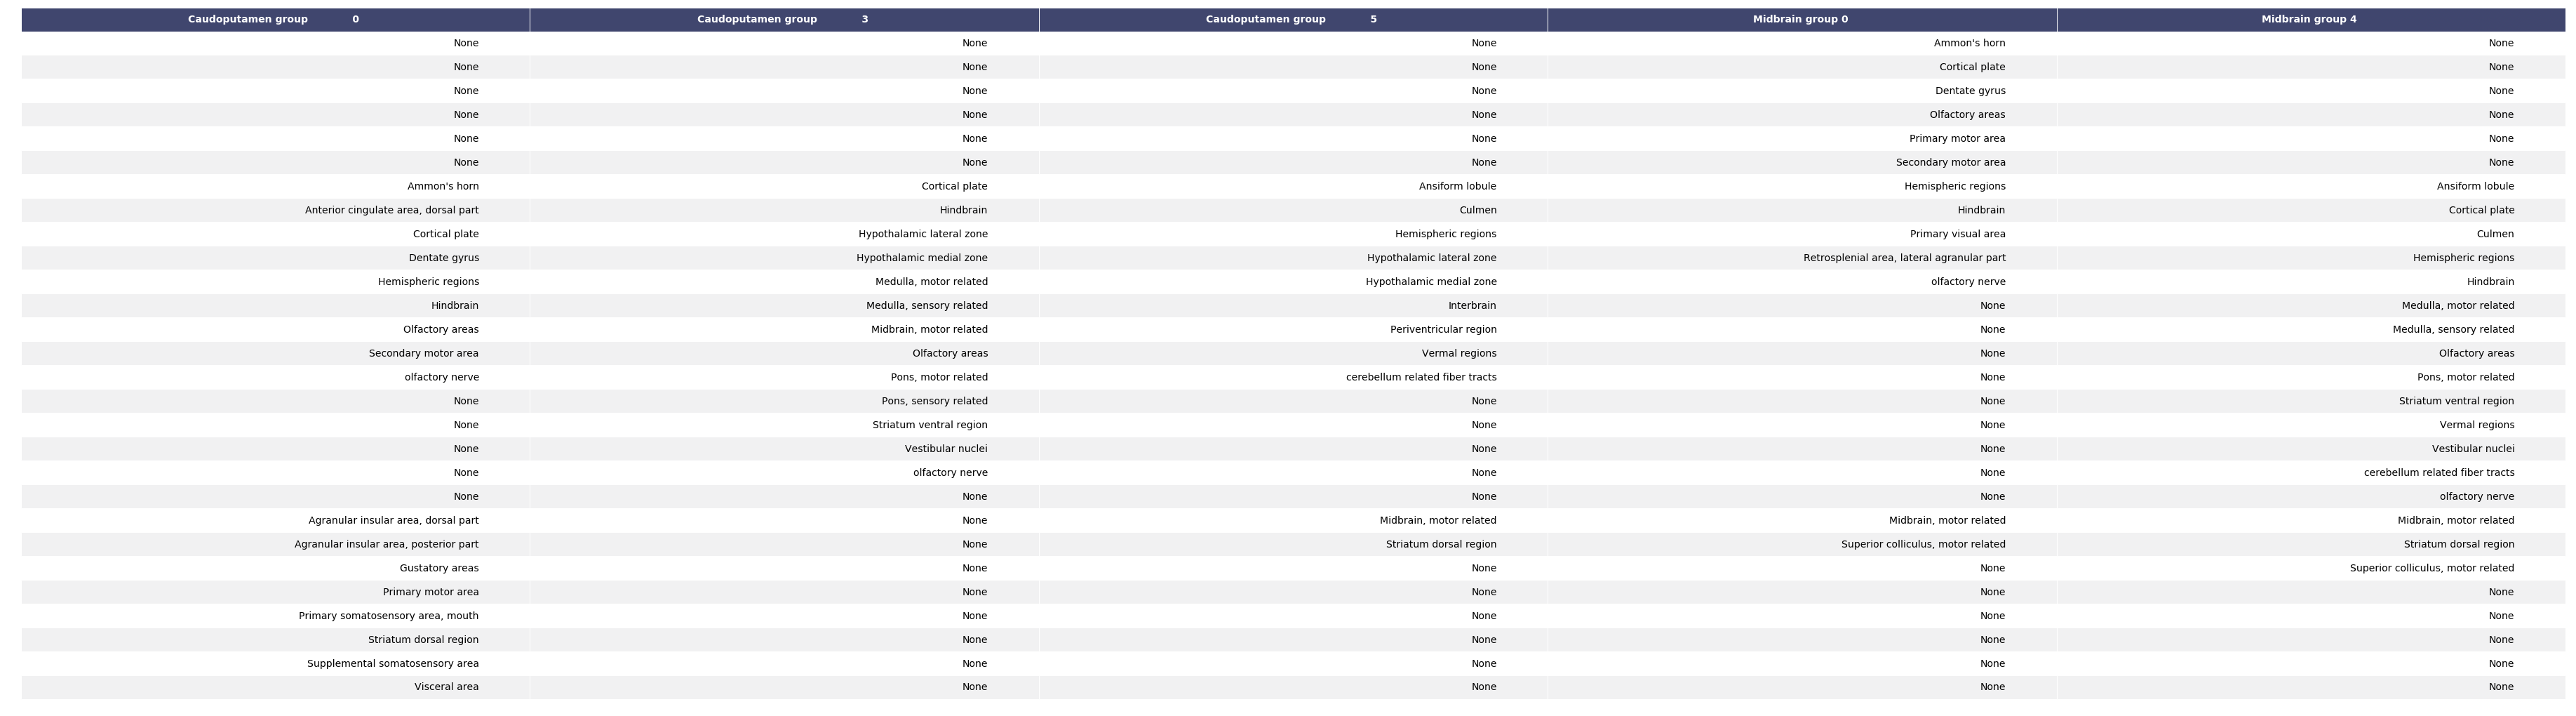

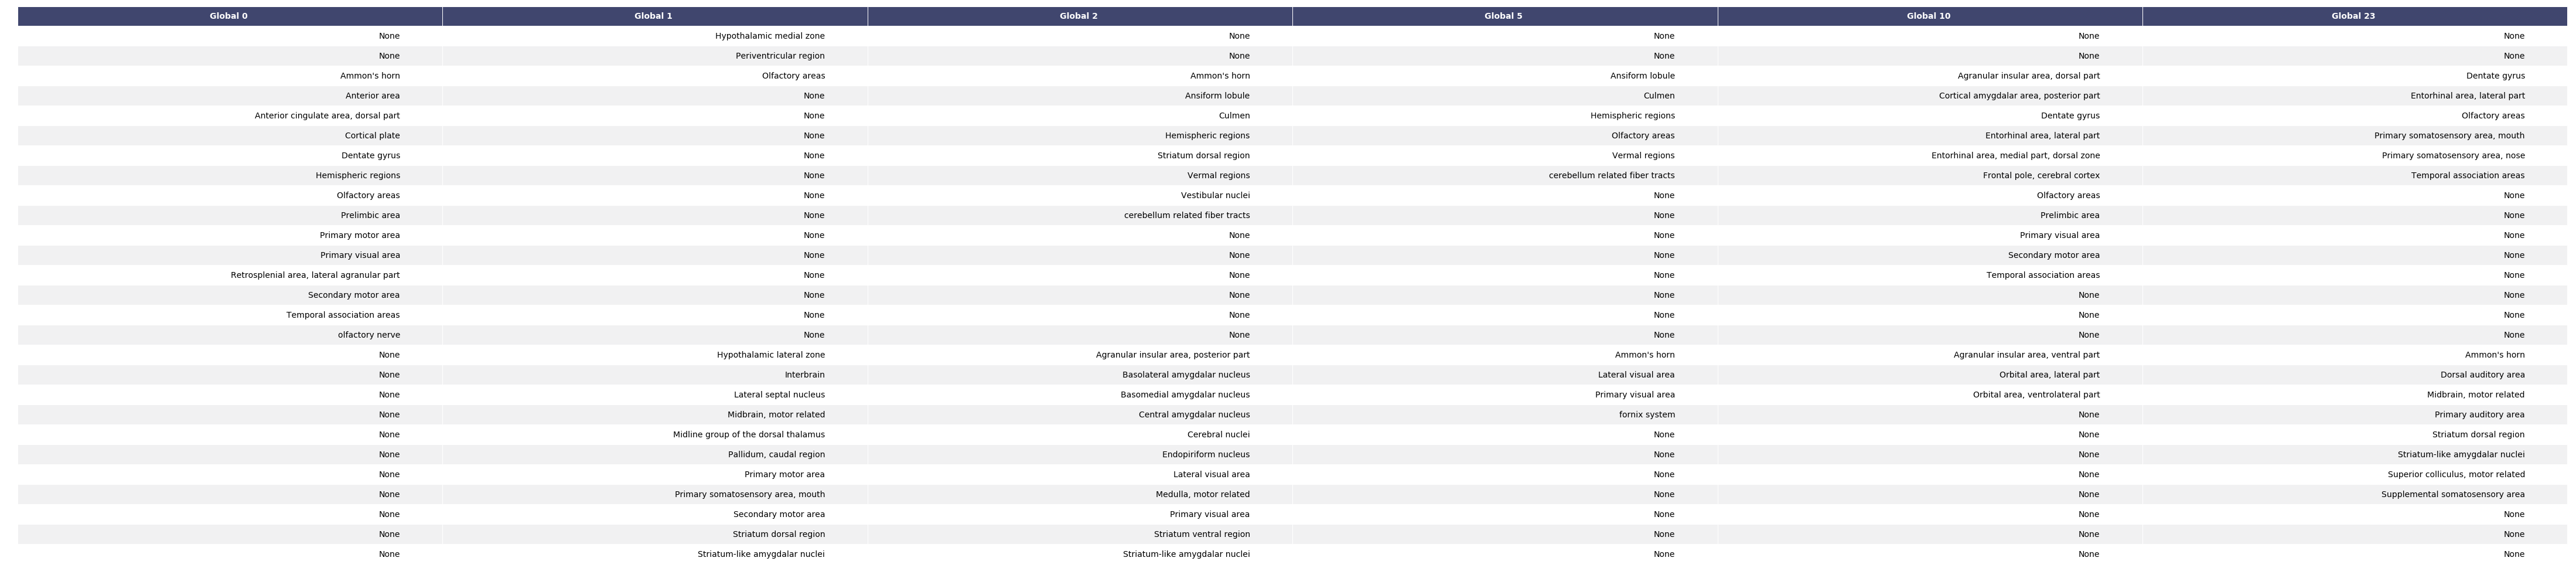

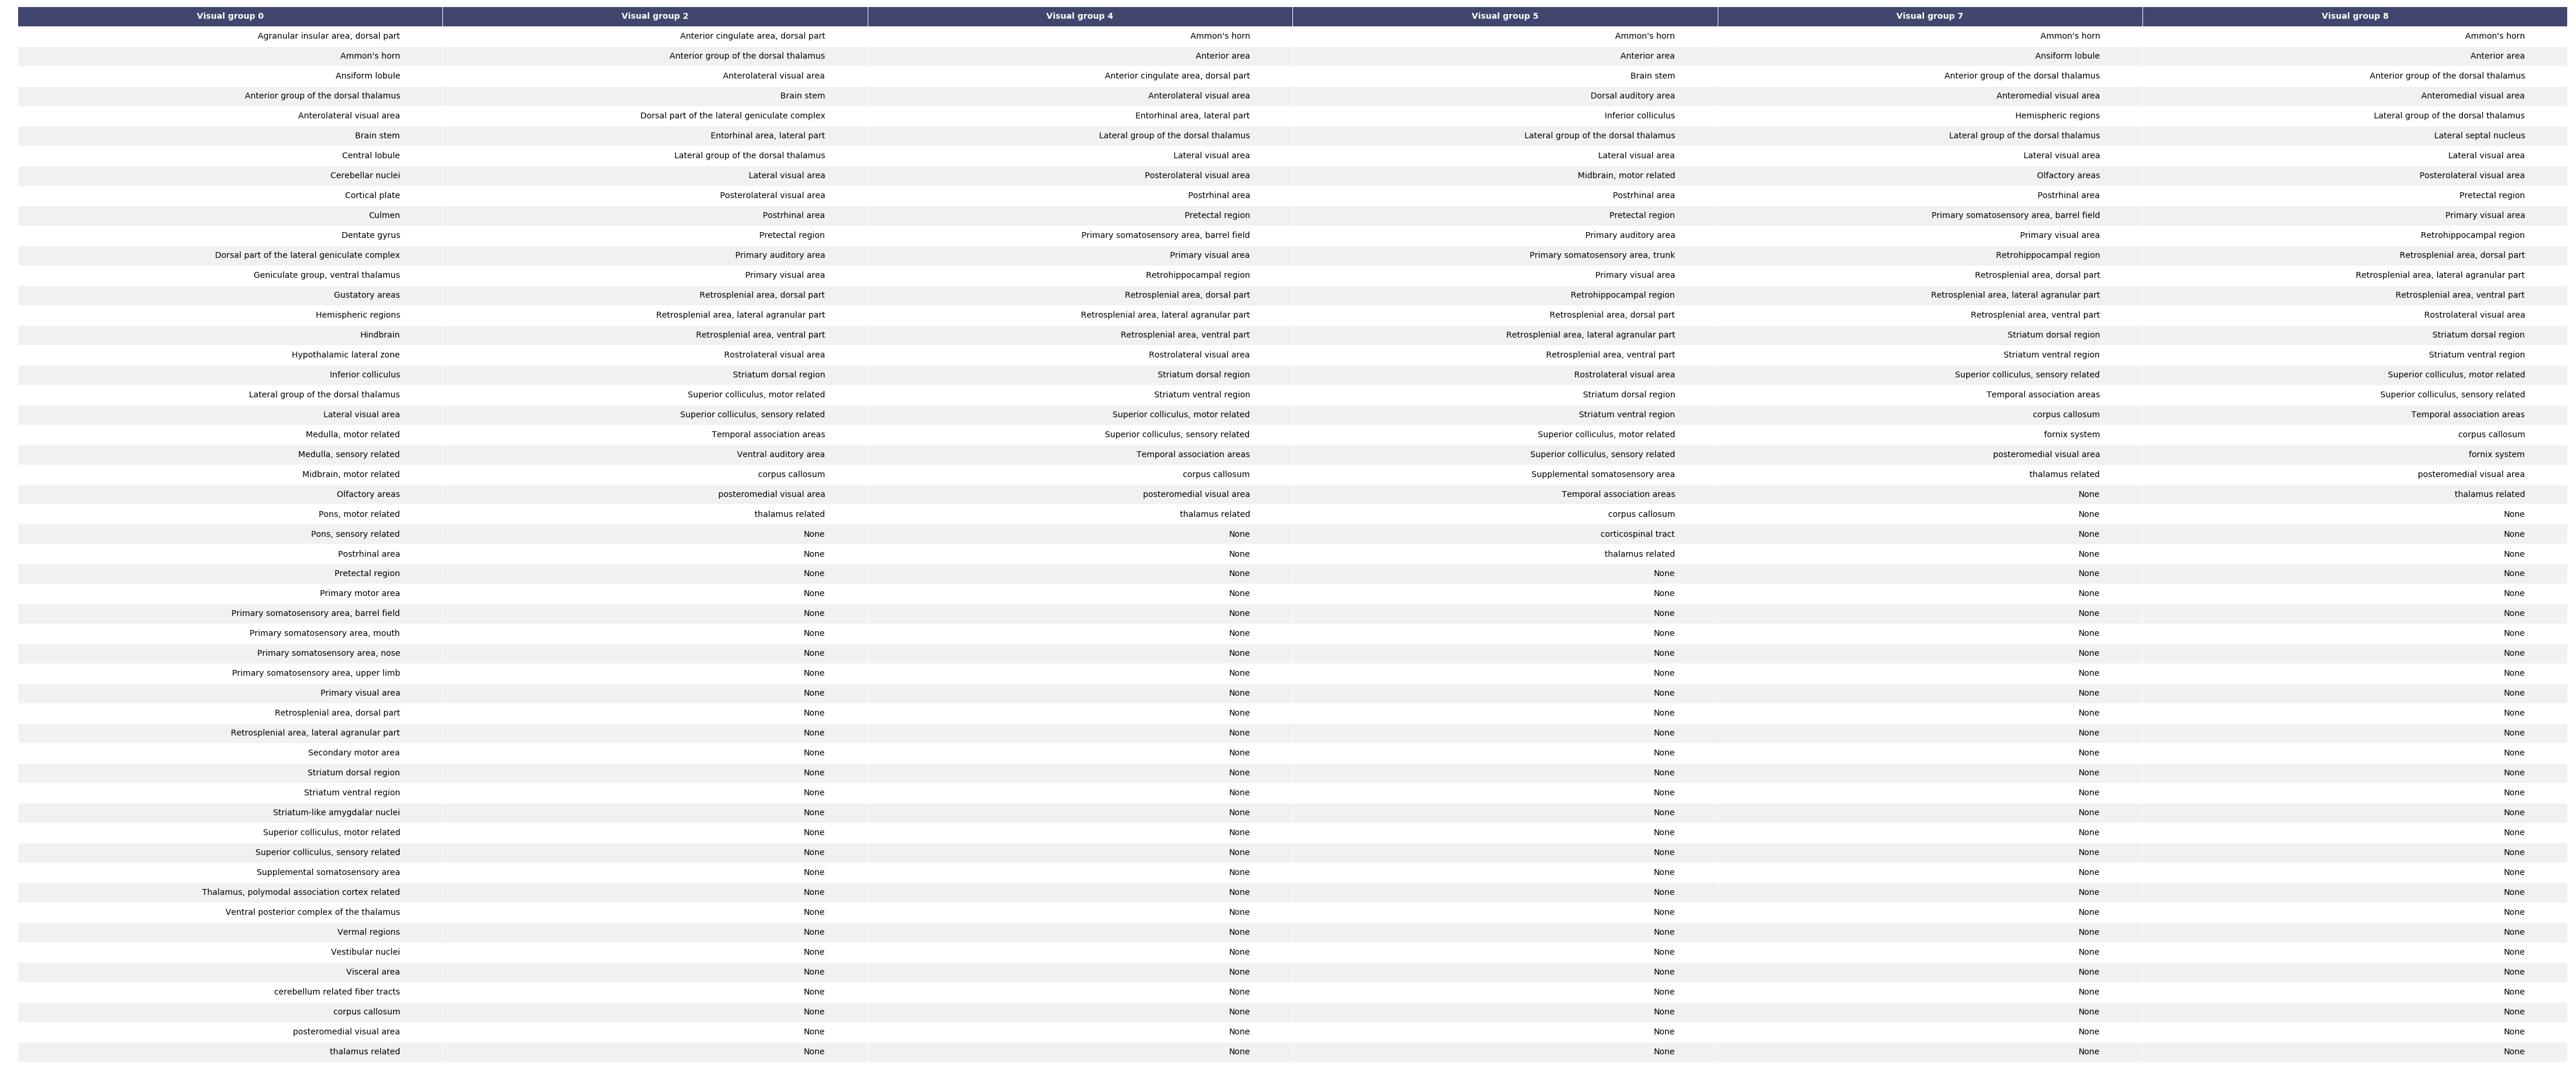

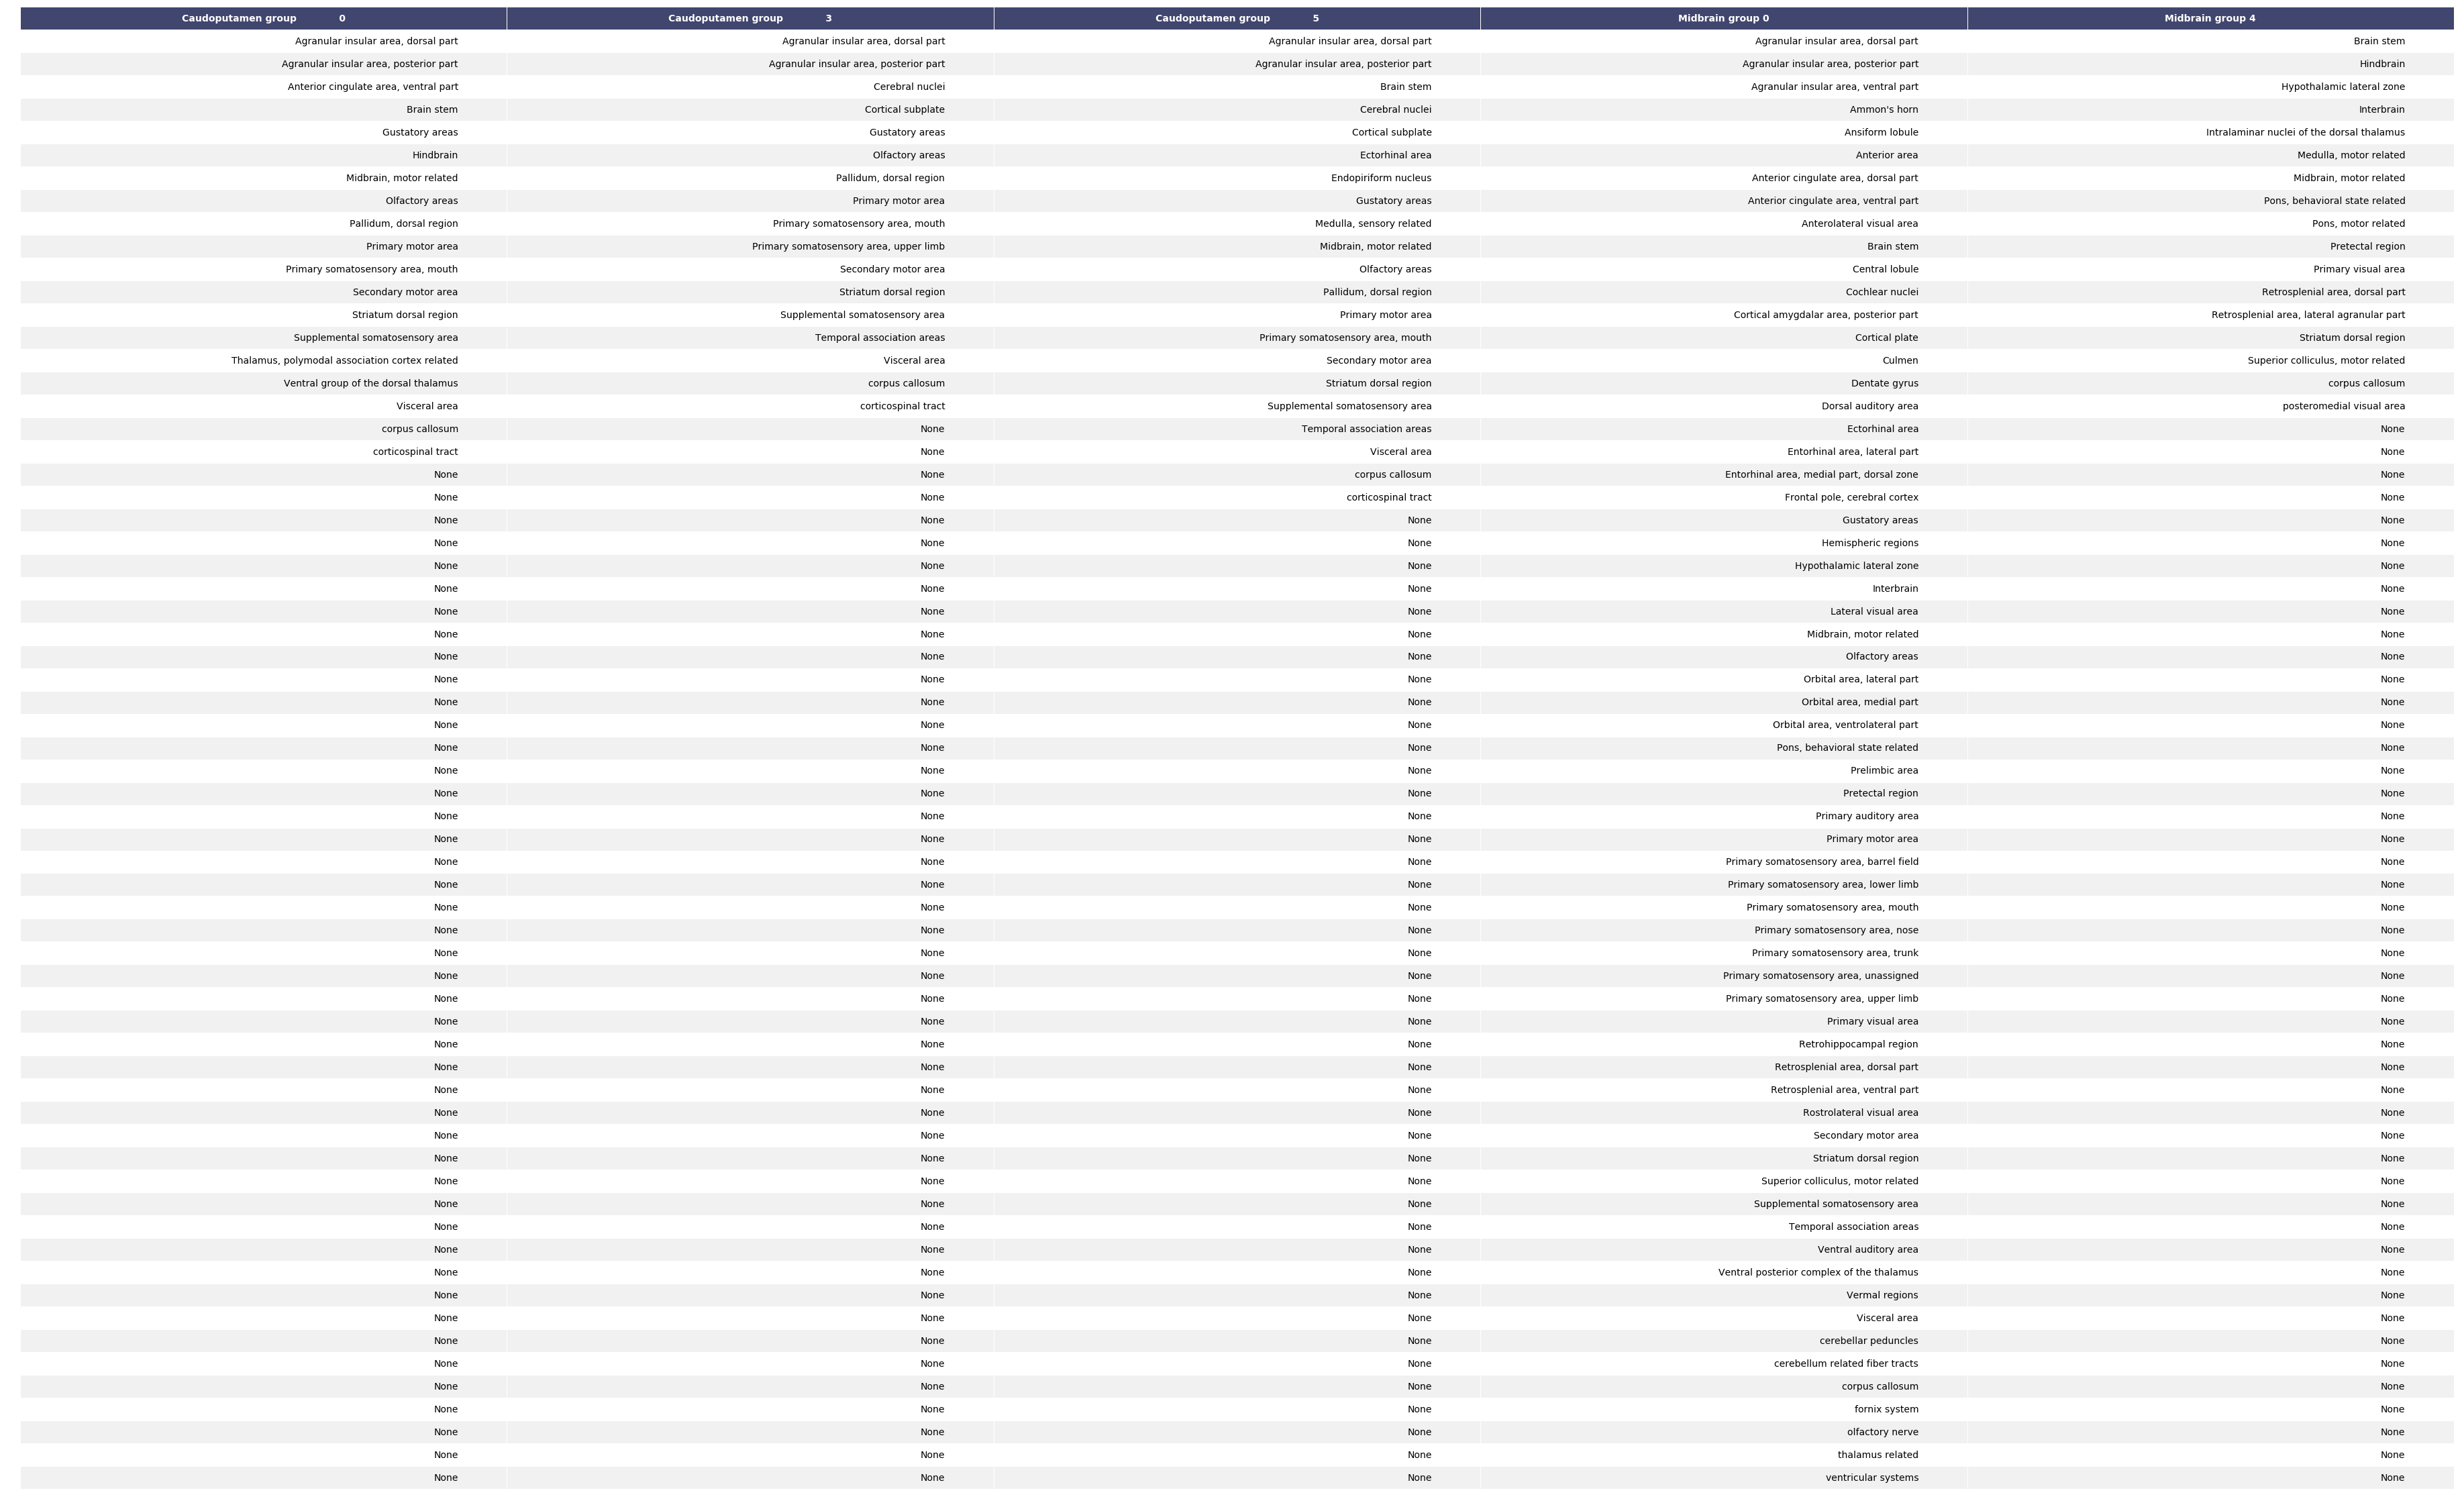

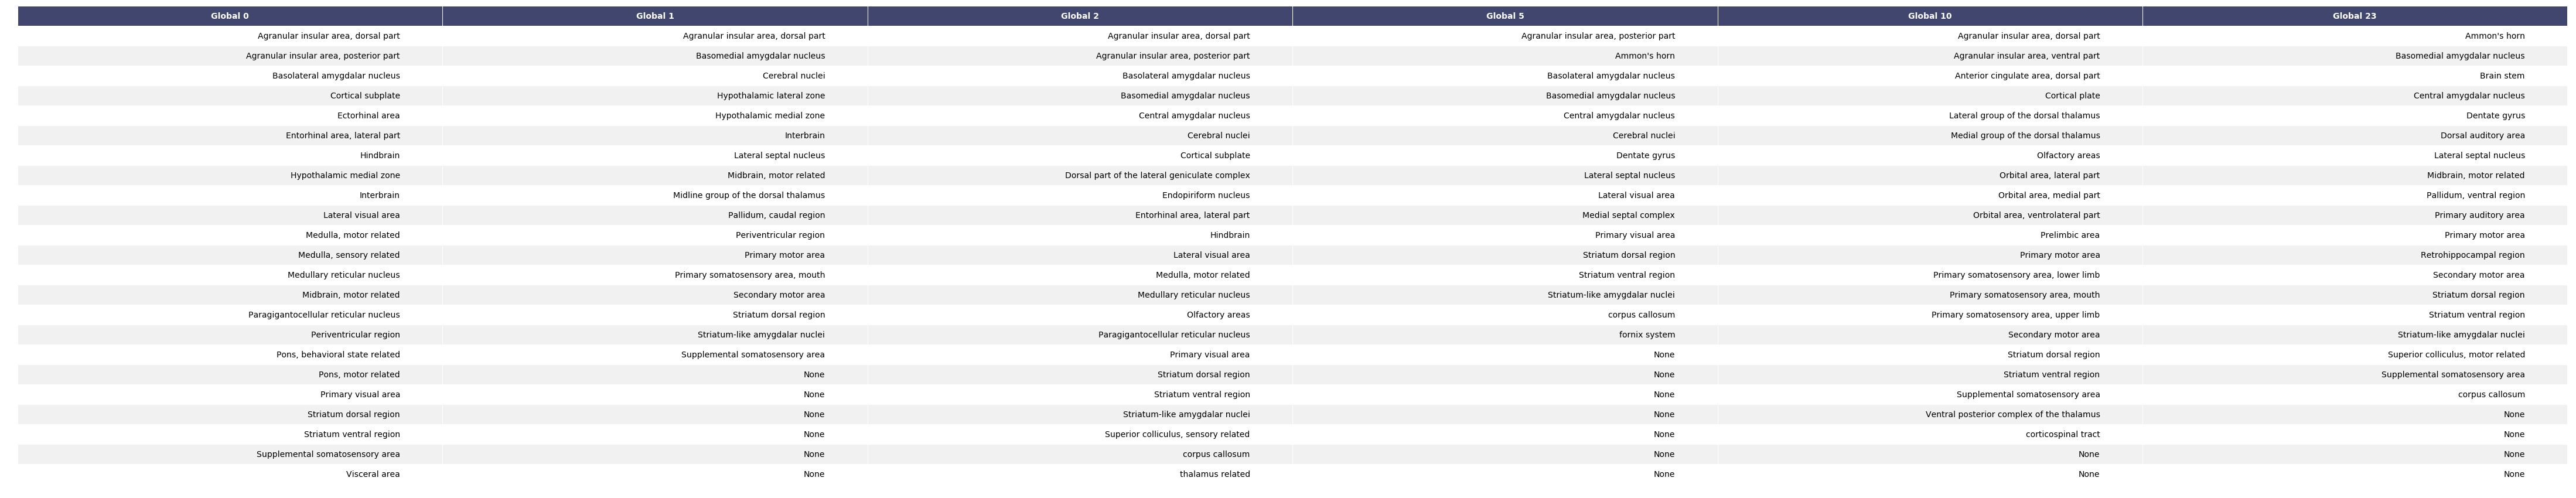

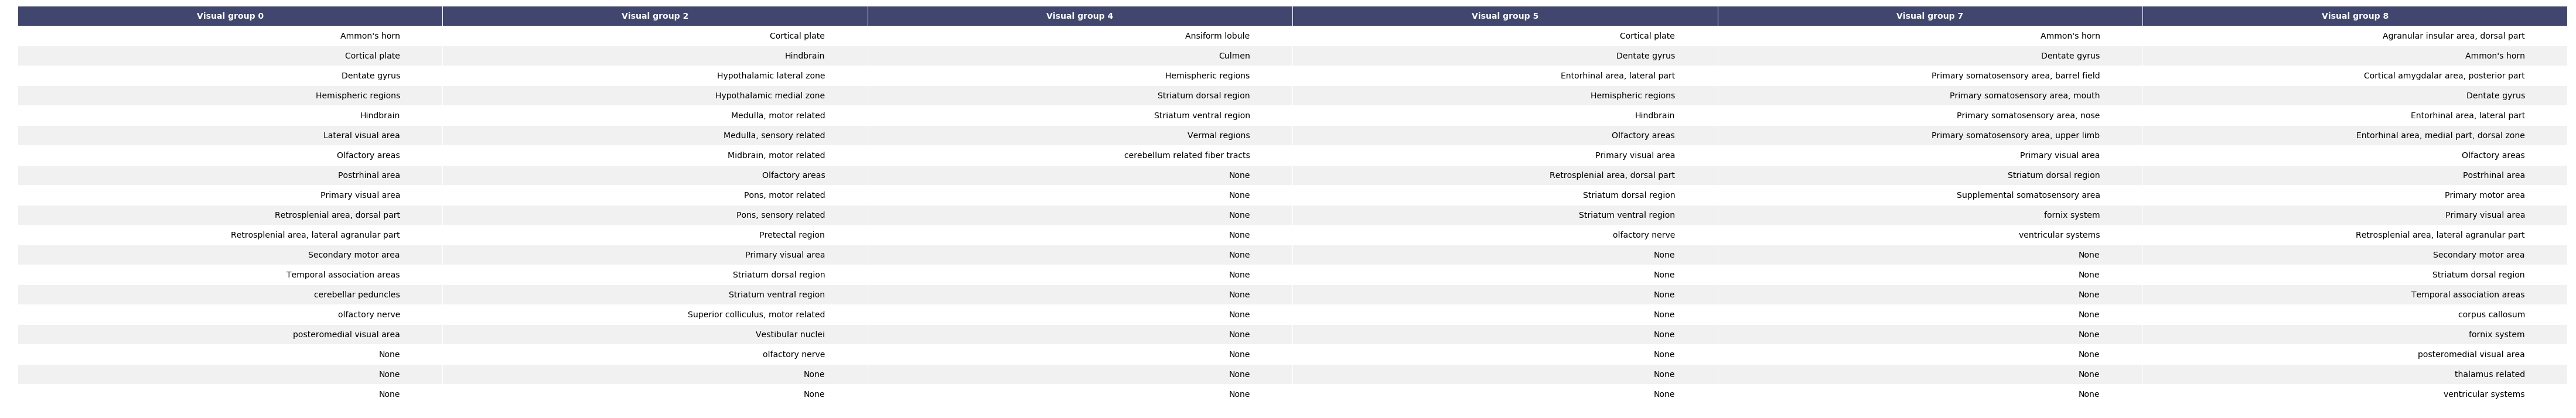

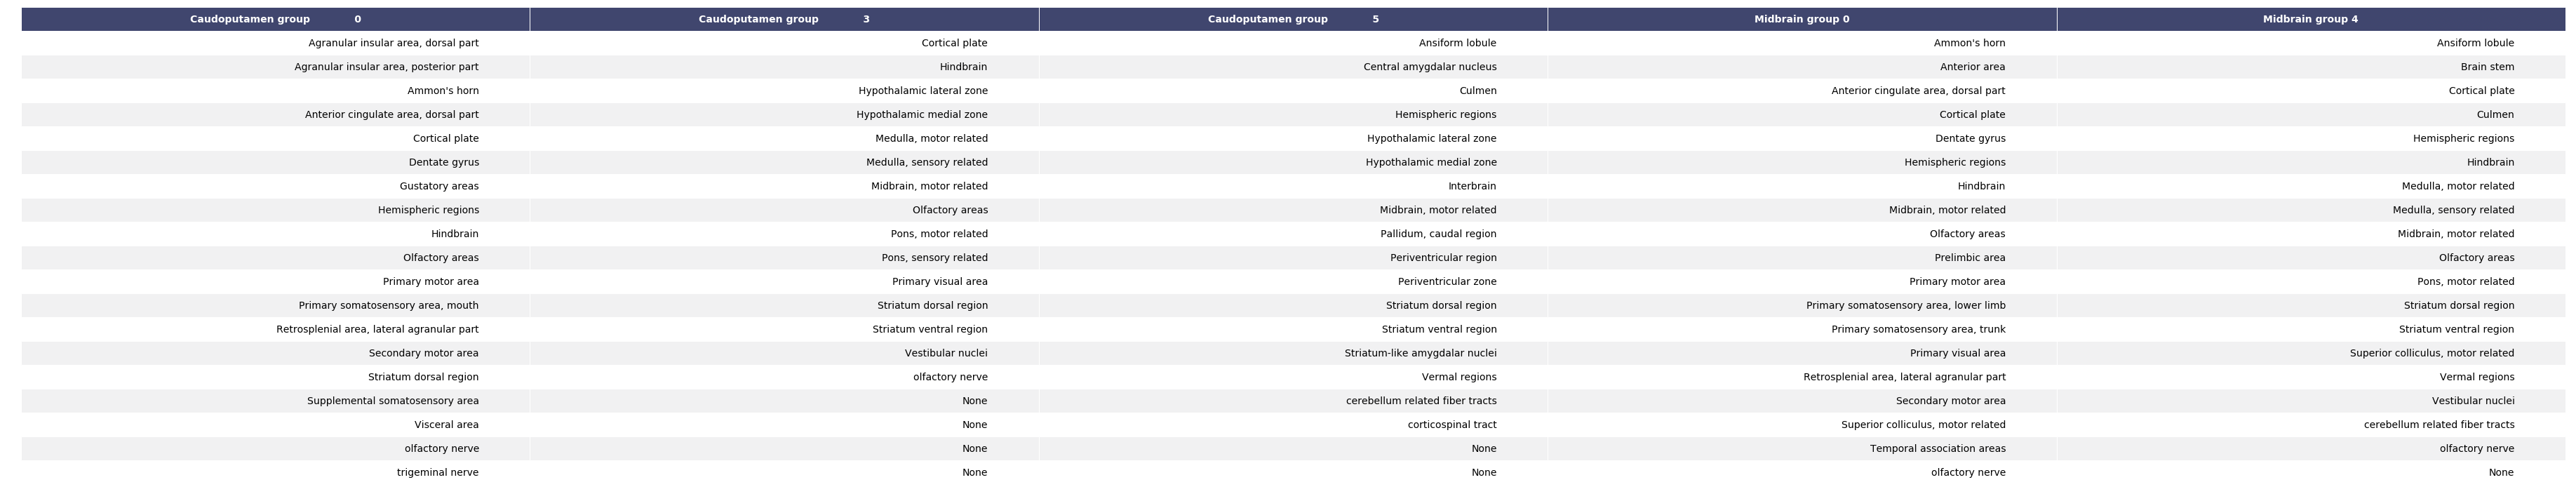

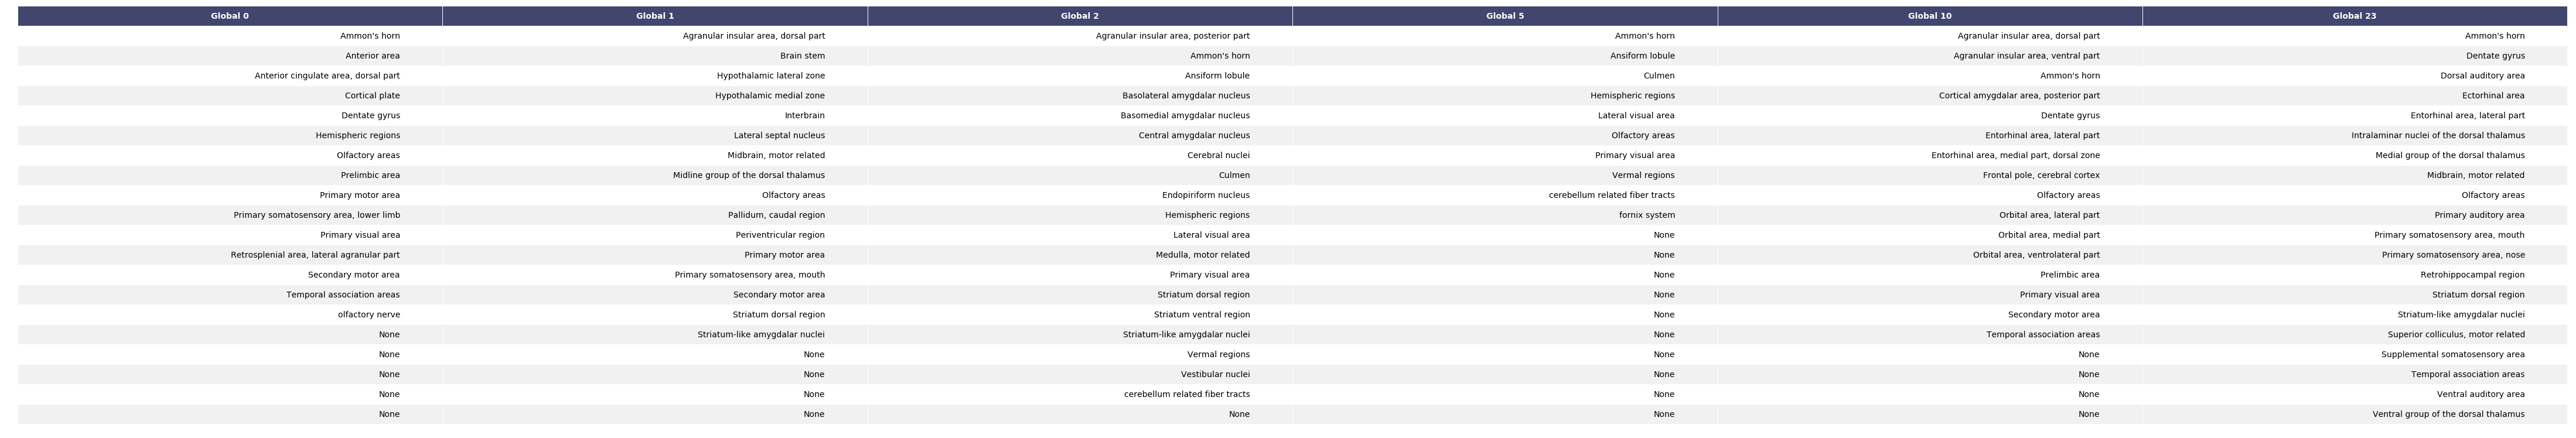

In [7]:
thr = 40
SummaryDict, Tasic_ovp_df, MixDict, TractographyDict, MixDict_test_df, total_ccode_dict  = FL.ColorcodingRoutine(InputData,\
                                                                                                                 annotation200, thr)
clear_output()

source = {'Visual':'Primary visual area','Midbrain': 'Midbrain reticular nucleus', 'Caudoputamen':'Caudoputamen'}
thr = 0.1

groups = [['Visual'],['Midbrain','Caudoputamen'],['Global']]
groups2 = ['bimodal','gene','projection']
for group in groups:
    for j,group2 in enumerate(groups2):
        tmp_list = []
        SummaryDict_subgrp = OrderedDict([(key,val) for key,val in SummaryDict.items() \
                                          for memb in group if memb in key and group2 in key])
        tmp_vals = list(SummaryDict_subgrp.values())
        max_subgrp = np.max([len(tmp_vals[i]) for i in range(len(tmp_vals))])
        group_column = [group2.replace('projection','projection density driven')\
                        .replace('gene','gene expression driven') for i in range(max_subgrp)]
        injection_subgrp = [key.replace('projection density driven','')\
                            .replace('gene expression driven','').replace('bimodal','') \
                            for key in SummaryDict_subgrp.keys()]
        if j == 0:
            SummaryDf = pd.DataFrame(tmp_vals, index=injection_subgrp,\
                                 columns = group_column).T
        else: # merge the dictionary with the previous one
            SummaryDf = pd.concat([SummaryDf, pd.DataFrame(tmp_vals, index=injection_subgrp,\
                                 columns = group_column).T], axis = 0)    
        print group,group2
    PL.render_mpl_table(SummaryDf)
    #print SummaryDf.to_latex()
    print '\n\n'

for group in groups:
    TractographyDict_subgrp = OrderedDict([(key,val) for key,val in TractographyDict.items() \
                                           for memb in group if memb in key])
    TractDf = pd.DataFrame(list(TractographyDict_subgrp.values()), index=TractographyDict_subgrp.keys()).T
    print group
    PL.render_mpl_table(TractDf)
    #print TractDf.to_latex()
    print '\n\n'
    
    
for group in groups:
    MixDict_subgrp = OrderedDict([(key,val) for key,val in MixDict.items() for memb in group if memb in key])
    MixDf = pd.DataFrame(list(MixDict_subgrp.values()), index = MixDict_subgrp.keys()).T
    print group
    PL.render_mpl_table(MixDf)
    #print MixDf.to_latex()
    print '\n\n'    

### Calling the BuildInjectionSubsets function to build projection subsets with sources originating at the densest sampled brain areas

In [19]:
sources = MesoPred.params['structure-abbrev'] # I think so
new_masks = FL.BuildInjectionSubsets(Data_Modality[1], sources, filename = 'masks_4_wild_type_beta')

inj_dict = OrderedDict()
unique_srcs = np.unique(sources)
for src in unique_srcs:
    inj_dict[src] = len([idx for idx,val in enumerate(sources) if val == src])
inj_df = pd.DataFrame(inj_dict, index = ['injection frequency'], columns = inj_dict.keys()).T
inj_df = inj_df.sort_values(by='injection frequency')[::-1]
inj_df_sub = inj_df.loc[inj_df['injection frequency'] > 5]
#inj_df_sub.to_latex()
inj_df_sub

,injection frequency
VISp,33
CP,19
MRN,16
ENTl,10
DG,9
PAG,9
MOs,9
MD,8
ENTm,8
CA3,8


### Taking pairwise correlations between spatial maps of local and global components and for each local component of interest find the global one with the best match

In [51]:
import decimal
M_glob = pk.load(open('data/Outputs_O_param_200/M.p','rb')) 
M_glob['W'] = np.asarray(M_glob['W'])
LoadDict = OrderedDict([('data/Outputs_O_param_source_vis_all/',[0,2,4,5,7,8]),\
                ('data/Outputs_O_param_200_source_cp/',[0,3,5]),\
                ('data/Outputs_O_param_200_source_mrn/', [0,4])])

Gl2Loc_dict = OrderedDict()        
for folder2check, comps_to_check in LoadDict.items():
    
    M_loc = pk.load(open(os.path.join(folder2check,'M.p'),'rb'))
    injection_group = folder2check.split('source_')[1].split('/')[0]
    new_masks = pk.load(open('saves/masks_4_wild_type_{}.pkl'.format(injection_group),'rb'))
    M_loc['W'] = np.asarray(M_loc['W'])
    M_glob_h = M_glob['H'][:,new_masks['vox_mask']]

    Gl2Loc = np.zeros((len(M_loc['H']),len(M_glob_h)))
    for l_i in range(len(M_loc['H'])):
        for g_i in range(len(M_glob_h)):
            Gl2Loc[l_i,g_i] = sci.stats.pearsonr(np.abs(M_loc['H'][l_i,:]),np.abs(M_glob_h[g_i,:]))[0]
            
    for comp in comps_to_check:
        final_key = injection_group + '_' + str(comp)
        final_key = final_key.replace('vis_all','vis ICA').replace('cp','cp ICA\
                    ').replace('mrn', 'mrn ICA').replace('_',' ').replace('global', 'Global ICA')   
        print final_key
        max_glob_id = np.argmax(Gl2Loc[comp,:])
        max_glob_val = np.max(Gl2Loc[comp,:])
        max_glob_p   = sci.stats.pearsonr(np.abs(M_loc['H'][comp,:]),np.abs(M_glob_h[max_glob_id,:]))[1]
        gene_coef_cor = sci.stats.pearsonr(np.abs(M_loc['X'][0][:,comp]),np.abs(M_glob['X'][0][:,max_glob_id]))
        source_coef_cor = sci.stats.pearsonr(np.abs(M_loc['X'][1][:,comp]),\
                                             np.abs(M_glob['X'][1][new_masks['source_mask'],max_glob_id]))
        Gl2Loc_dict[final_key] = OrderedDict([('global ICA', max_glob_id), \
                                            ('spatial map rho', max_glob_val), \
                                            #('spatial map p', max_glob_p),\
                                            ('gene coefficient rho', gene_coef_cor[0])])
        Gl2Loc_dict[final_key]['gene coefficient p'] = gene_coef_cor[1]
        Gl2Loc_dict[final_key]['source coefficient rho'] = source_coef_cor[0]
        Gl2Loc_dict[final_key]['source coefficient p'] = source_coef_cor[1]    
        #print comp, max_glob_id, max_glob_val, gene_coef_cor[0],gene_coef_cor[1], source_coef_cor[0],source_coef_cor[1]     

for key,value in Gl2Loc_dict.items():
    for key2 in value.keys():
        if ' p' not in key2:
            Gl2Loc_dict[key][key2] = np.around(Gl2Loc_dict[key][key2],decimals = 3)
        else:    
            Gl2Loc_dict[key][key2] = ('%.1E' % decimal.Decimal(Gl2Loc_dict[key][key2]))
Gl2Loc_df = pd.DataFrame(Gl2Loc_dict,index = Gl2Loc_dict[Gl2Loc_dict.keys()[0]].keys(),columns = Gl2Loc_dict.keys()).T
Gl2Loc_df = Gl2Loc_df.astype({'global ICA': 'int32'}, copy = False)
for column in Gl2Loc_df.columns:
    if column is not 'global ICA': continue
    if 'p' in column: Gl2Loc_df = Gl2Loc_dict.astype({column: 'float64'}, copy = False)
    else: Gl2Loc_df = Gl2Loc_dict.astype({column: 'float8'}, copy = False)
#print Gl2Loc_df.to_latex()
Gl2Loc_df

vis ICA 0
vis ICA 2
vis ICA 4
vis ICA 5
vis ICA 7
vis ICA 8
cp ICA                     0
cp ICA                     3
cp ICA                     5
mrn ICA 0
mrn ICA 4


,global ICA,spatial map rho,gene coefficient rho,gene coefficient p,source coefficient rho,source coefficient p
vis ICA 0,0,0.833,0.997,0.0E+00,0.934,1.1E-21
vis ICA 2,1,0.52,0.876,0.0E+00,0.252,8.8E-02
vis ICA 4,5,0.528,0.8,0.0E+00,0.414,3.8E-03
vis ICA 5,2,0.461,0.577,3.7E-294,-0.129,3.9E-01
vis ICA 7,23,0.407,0.465,7.2E-178,0.5,3.5E-04
vis ICA 8,10,0.588,0.757,0.0E+00,0.293,4.6E-02
cp ICA 0,0,0.94,0.999,0.0E+00,0.95,4.7E-10
cp ICA 3,1,0.507,0.868,0.0E+00,0.467,4.4E-02
cp ICA 5,5,0.603,0.844,0.0E+00,0.251,3.0E-01
mrn ICA 0,0,0.936,0.997,0.0E+00,0.884,5.6E-06


### Comparing dictionary learning and sparse coding results with Linked ICA components

In [50]:
comp_set = [0,1,2,4,5,10,23]
Dict2Loc_df, LICA_2_dict_df = FL.PairwiseVoxelCorrelation(comp_set)
#print Dict2Loc_df.to_latex()
#print Dict2Loc_df[['Gene Dictionary', 'A1 rho', 'A1 p', 'A2 rho', 'A2 p']].to_latex()
#print Dict2Loc_df[['Projection Dictionary', 'B1 rho', 'B1 p', 'B2 rho', 'B2 p']].to_latex()
Dict2Loc_df[['Gene Dictionary', 'A1 rho', 'A1 p', 'A2 rho', 'A2 p']]
Dict2Loc_df[['Projection Dictionary', 'B1 rho', 'B1 p', 'B2 rho', 'B2 p']]
for key in LICA_2_dict_df.keys():
    for key2 in LICA_2_dict_df[key].keys():
        LICA_2_dict_df[key][key2] = np.around(LICA_2_dict_df[key][key2],decimals = 3)
#print LICA_2_dict_df.to_latex()    
LICA_2_dict_df

0
1
2
4
5
10
23


,Concat Dictionary,Pearson rho,Pearson p,C,D,E
0,182,0.285,0.0,0.787,0.447,0.964
1,47,0.449,0.0,0.422,0.713,0.470
2,10,0.362,0.0,0.381,0.867,0.364
4,129,0.412,0.0,0.356,0.694,0.165
5,43,0.249,0.0,0.689,0.485,0.588
10,92,0.250,0.0,0.439,0.276,0.718
23,4,0.326,0.0,0.468,0.571,0.447


### Compare DLSC with FLICA on reconstruction accuracy and predictive performance

LICA gene rec r2 score: 0.679276427274
LICA projection rec r2 score: 0.637761268565
LICA gene rec MSE score: 0.167996516483 - 486.459216934 - 321.971885238
LICA projection rec MSE score: 0.112374546405 - 19.2237779682 - 63.424284649


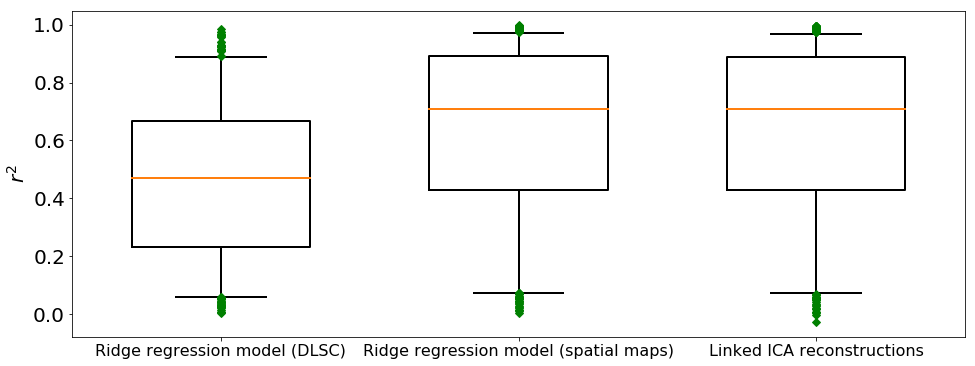

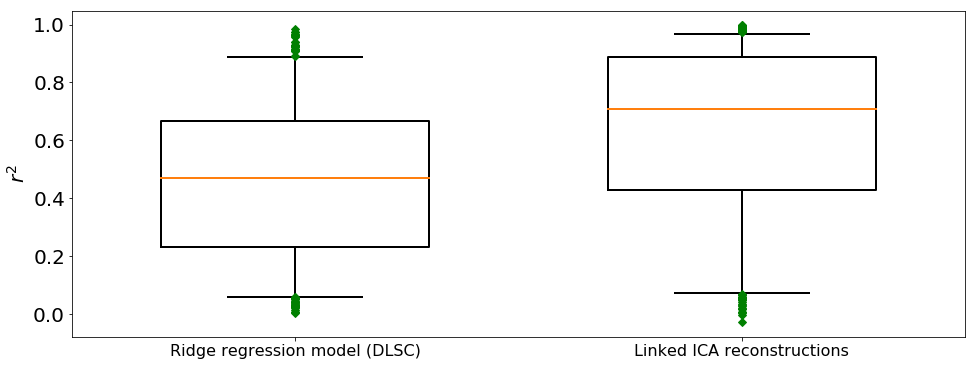

Ttest_relResult(statistic=-30.617411275686138, pvalue=1.8009680683902024e-116)
-30.85348632242401 1.4724003916686843e-117 -4.496567211862319 8.603670816401026e-06


,exclusive-DLSC gene,exclusive-DLSC projection,concat-DLSC gene,concat-DLSC projection,linked-ICA gene,linked-ICA projection
MSE,0.149055,0.058867,0.163962,0.289829,0.167997,0.112375
r2,0.666807,0.695228,0.646302,0.451131,0.679276,0.637761


In [25]:
#CC_code = Conc_code; CC_atom = Conc_atom 
ReconDict = {'r2': OrderedDict(),'MSE': OrderedDict()}
G_atom = pk.load(open('temp_saves/Atoms_4_GeneVol.pkl','rb'))
P_atom = pk.load(open('temp_saves/Atoms_4_ProjVol.pkl','rb'))
G_code = pk.load(open('temp_saves/Code_4_GeneVol.pkl','rb'))
P_code = pk.load(open('temp_saves/Code_4_ProjVol.pkl','rb'))
CC_atom = pk.load(open('temp_saves/Atoms_4_GeneVol_conc.pkl','rb'))
CC_code = pk.load(open('temp_saves/Code_4_GeneVol_conc.pkl','rb'))
Data_Modality_sc[0] = np.asarray(Data_Modality_sc[0])
Data_Modality_sc[1] = np.asarray(Data_Modality_sc[1])

# Step 0: reconstruction from exclusive dictionaries
ReconGene_d = np.matmul(G_code,G_atom).T
ReconProj_d = np.matmul(P_code,P_atom).T
gene_mat_diff = (Data_Modality_sc[0].T-ReconGene_d)
con_mat_diff  = (Data_Modality_sc[1].T-ReconProj_d)
 
g_MSE = np.power(gene_mat_diff,2).mean(axis=None)
c_MSE = np.power(con_mat_diff,2).mean(axis=None)
g_RSS = np.power(gene_mat_diff,2).sum(axis=1)
c_RSS = np.power(con_mat_diff,2).sum(axis=1)
g_r2  = metrics.r2_score(Data_Modality_sc[0].T,ReconGene_d)
c_r2  = metrics.r2_score(Data_Modality_sc[1].T,ReconProj_d)
ReconDict['r2']['exclusive-DLSC gene'] = g_r2
ReconDict['r2']['exclusive-DLSC projection'] = c_r2
ReconDict['MSE']['exclusive-DLSC gene'] = g_MSE
ReconDict['MSE']['exclusive-DLSC projection'] = c_MSE
 
print 'Exclusive gene rec r2 score: {}'.format(g_r2)
print 'Exclusive projection rec r2 score: {}'.format(c_r2)
print 'Exclusive gene rec MSE score: {} - {} - {}'.format(g_MSE, np.median(g_RSS), sci.stats.iqr(g_RSS))
print 'Exclusive projection rec MSE score: {} - {} - {}'.format(c_MSE, np.median(c_RSS), sci.stats.iqr(c_RSS))

# Step 1: decouple reconstructions back to their original set
Reconstruct = np.matmul(CC_code,CC_atom)
G2_code = CC_code[0:3318,:]; P2_code = CC_code[3318:len(CC_code),:] 

# Step 2: reconstruct the original arrays
RecMod1 = np.matmul(G2_code,CC_atom)
RecMod2 = np.matmul(P2_code,CC_atom)
gene_mat_diff_conc = (Data_Modality_sc[0].T-RecMod1.T)
con_mat_diff_conc  = (Data_Modality_sc[1].T-RecMod2.T)
g_MSE_conc = np.power(gene_mat_diff_conc,2).mean(axis=None)
c_MSE_conc = np.power(con_mat_diff_conc,2).mean(axis=None)
g_RSS_conc = np.power(gene_mat_diff_conc,2).sum(axis=1)
c_RSS_conc = np.power(con_mat_diff_conc,2).sum(axis=1)
g_r2_conc  = metrics.r2_score(Data_Modality_sc[0].T,RecMod1.T)
c_r2_conc  = metrics.r2_score(Data_Modality_sc[1].T,RecMod2.T)
ReconDict['r2']['concat-DLSC gene'] = g_r2_conc
ReconDict['r2']['concat-DLSC projection'] = c_r2_conc
ReconDict['MSE']['concat-DLSC gene'] = g_MSE_conc
ReconDict['MSE']['concat-DLSC projection'] = c_MSE_conc

# Step 3: estimate r2
print 'Concatenated gene rec r2 score: {}'.format(g_r2_conc)
print 'Concatenated projection rec r2 score: {}'.format(c_r2_conc)
print 'Concatenated gene rec MSE score: {} - {} - {}'.format(g_MSE_conc, np.median(g_RSS_conc), \
                                                             sci.stats.iqr(g_RSS_conc))
print 'Concatenated projection rec MSE score: {} - {} - {}'.format(c_MSE_conc, np.median(c_RSS_conc), \
                                                                   sci.stats.iqr(c_RSS_conc))

# Step 4: predict projection density from mixed dictionaries
Y_dict_proj, r2_dict_proj, mdls_dict_proj = PL.GeneralizedCCP(CC_atom.T,Data_Modality_sc[1].T, style = 'all')
dlsc_reg_mat_diff  = (Data_Modality_sc[1].T-Y_dict_proj)
dlsc_reg_MSE = np.power(dlsc_reg_mat_diff,2).mean(axis=None)
print 'Prediction from dictionary r2 score: {}'.format(metrics.r2_score(Data_Modality_sc[1].T,Y_dict_proj))
print 'Prediction from concat-DLSC maps MSE: {}'.format(dlsc_reg_MSE)

# Step 5: predict projection density from mixed ICA maps using the CCP tool
Y_ICA_proj, r2_ICA_proj, mdls_ICA_proj = PL.GeneralizedCCP(M['H'].T,Data_Modality_sc[1].T, style = 'all')
lica_reg_mat_diff  = (Data_Modality_sc[1].T-Y_ICA_proj)
lica_reg_MSE = np.power(lica_reg_mat_diff,2).mean(axis=None)
print 'Prediction from spatial ICA maps r2 score: {}'.format(metrics.r2_score(Data_Modality_sc[1].T,Y_ICA_proj))
print 'Prediction from spatial ICA maps MSE: {}'.format(lica_reg_MSE) 

# Step 6: predict projection density from mixed ICA maps using the LICA's inbuilt generative model
ReconGene = FL.ReconstructingData(M,M['H'],0)
ReconProj = FL.ReconstructingData(M,M['H'],1)
ReconGene = np.asarray(ReconGene); ReconProj = np.asarray(ReconProj); 
GeneError = Data_Modality_sc[0] - ReconGene
ProjError = Data_Modality_sc[1] - ReconProj
#FL.ValidateTheResults(Data_Modality_sc[0].T,Data_Modality_sc[1].T,ReconGene.T,ReconProj.T,GeneError.T,ProjError.T)
#PredProj_ICA = FL.Predictingdata(M, Data_Modality_sc)
gene_mat_diff_lica = (Data_Modality_sc[0].T-ReconGene.T)
con_mat_diff_lica  = (Data_Modality_sc[1].T-ReconProj.T)
g_MSE_lica = np.power(gene_mat_diff_lica,2).mean(axis=None)
c_MSE_lica = np.power(con_mat_diff_lica,2).mean(axis=None)
g_RSS_lica = np.power(gene_mat_diff_lica,2).sum(axis=1)
c_RSS_lica = np.power(con_mat_diff_lica,2).sum(axis=1)
g_r2_lica  = metrics.r2_score(Data_Modality_sc[0].T,ReconGene.T)
c_r2_lica  = metrics.r2_score(Data_Modality_sc[1].T,ReconProj.T)
ReconDict['r2']['linked-ICA gene'] = g_r2_lica
ReconDict['r2']['linked-ICA projection'] = c_r2_lica
ReconDict['MSE']['linked-ICA gene'] = g_MSE_lica
ReconDict['MSE']['linked-ICA projection'] = c_MSE_lica

# Step 7: multioutput r2 values for all the predictive cases to be box-plotted together
r2_proj_dict = metrics.r2_score(Data_Modality_sc[1].T,Y_dict_proj, multioutput = 'raw_values')
r2_mixmap_in = metrics.r2_score(Data_Modality_sc[1].T,ReconProj.T, multioutput = 'raw_values')
print 'LICA gene rec r2 score: {}'.format(g_r2_lica)
print 'LICA projection rec r2 score: {}'.format(c_r2_lica)
print 'LICA gene rec MSE score: {} - {} - {}'.format(g_MSE_lica, np.median(g_RSS_lica), \
                                                             sci.stats.iqr(g_RSS_lica))
print 'LICA projection rec MSE score: {} - {} - {}'.format(c_MSE_lica, np.median(c_RSS_lica), \
                                                                   sci.stats.iqr(c_RSS_lica))

# Step 8: plotting the predictive performances
input_for_plot = [r2_proj_dict,r2_ICA_proj,r2_mixmap_in]
x_ticks = ['Ridge regression model (DLSC)','Ridge regression model (spatial maps)','Linked ICA reconstructions']
y_ticks = np.arange(0,1.1,0.2)
PL.Custom_Boxplot(input_for_plot,x_ticks = x_ticks, y_ticks = y_ticks, y_label = r'$r^2$',\
                  savefile='DLSC_FLICA_pred_comp.eps')

input_for_plot2 = [r2_proj_dict,r2_mixmap_in]
x_ticks2 = ['Ridge regression model (DLSC)','Linked ICA reconstructions']
PL.Custom_Boxplot(input_for_plot2,x_ticks = x_ticks2, y_ticks = y_ticks, y_label = r'$r^2$',\
                  savefile='DLSC_FLICA_pred_comp2.eps')
i
# Step 9: Pair-wise t-test between the r2 values of all three different forms of predictions
import scipy.stats as stats
t_stat1,pval1 = stats.ttest_rel(r2_proj_dict,r2_ICA_proj)
t_stat2,pval2 = stats.ttest_rel(r2_mixmap_in,r2_ICA_proj)
print stats.ttest_rel(r2_proj_dict,r2_mixmap_in)
print t_stat1,pval1,t_stat2,pval2
#pk.dump(r2_proj_dict,open('saves/r2_proj_dict.pkl','wb'))
#pk.dump(r2_ICA_proj,open('saves/r2_ICA_proj.pkl','wb'))
#pk.dump(r2_mixmap_in,open('saves/r2_mixmap_in.pkl','wb'))

ReconDf = pd.DataFrame(ReconDict, columns = ReconDict.keys(), \
                       index = ReconDict[list(ReconDict.keys())[0]].keys()).T
#print ReconDf.to_latex()
ReconDf

### Additional post-hoc statistics where for each component in a set:
#### a) its spatial map is being clustered (spectral clustering) and then normalized mutual information is being estimated between the spatial clusters and brain area labels provided by the Allen Annotation Volume.
#### b) correlation statistics (Pearson rho) are being estimated between its spatial map and the average template volume of gray matter provided by the Allen Institute for Brain Science.

(34215,) 0.3460438057613738


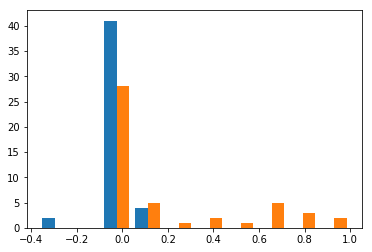

In [29]:
lica2gray, labels, nmi_score = FL.PostHocLICA(annotation200, Non_zero_voxels)

### Pre-Process the spatial maps of the dictionaries obtained using the DLSC approach and store them in NIfTI format for visualization purposes

In [49]:
'''dictionary_num = P_code.shape[1]; shape_of_200 = annotation200[0].shape
InputData = [G_atom,P_atom]
Dict_Modality,Dict_Modality_sc,Nzero = FL.PreProcessing(InputData)
comp_set = np.arange(2)'''

# Volume storage
FL.VolumeBuilder(Dict_Modality, Nzero, comp_set, shape_of_200, outfile = 'saves')

(0, (67, 41, 58, 2))
(1, (67, 41, 58, 2))
